In [1]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

In [2]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(country="United States", downsample_factor=80)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


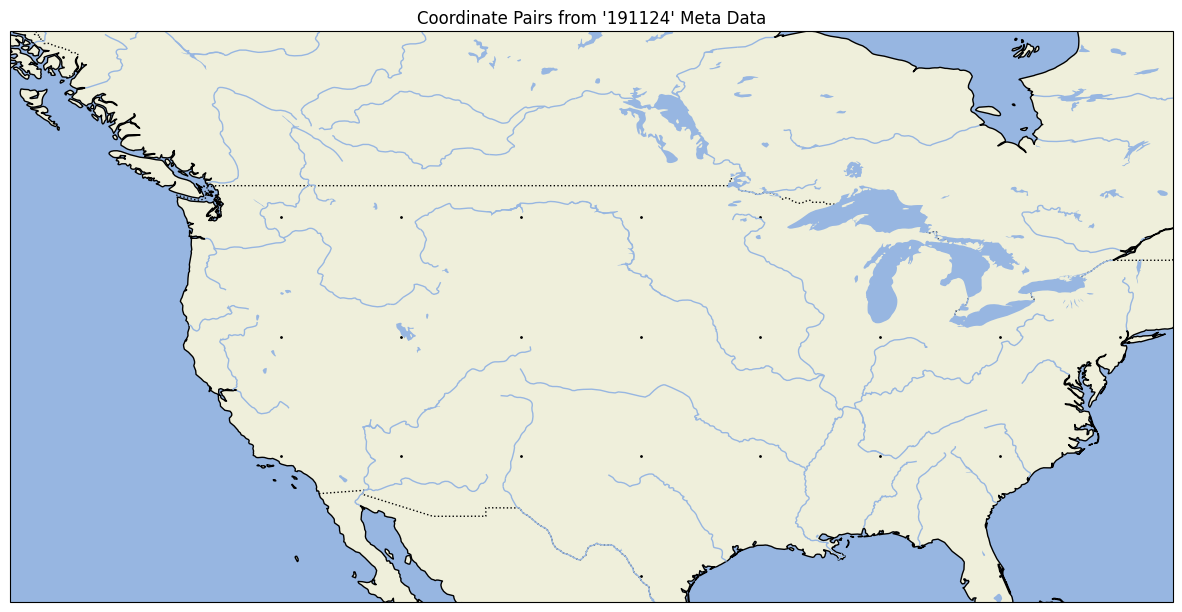

In [3]:
locationGetter.plot_coords()

In [3]:
geo_weather, geo_meta = locationGetter.geospatial_data()

geo_meta = geo_meta[geo_meta['state'] != "Alaska"]
geo_weather = geo_weather.sel(gid=geo_meta.index)

In [4]:
shapes = {
    "annual_poa" : ("gid",),
    "ground_irradiance" : ("gid", "time", "distance")
}

template = pvdeg.geospatial.output_template(
    ds_gids = geo_weather,
    shapes = shapes,
    add_dims={"distance" : 10}, # this will autogenerate a range of length 10 for the coordinate axis
)

In [5]:
pysam_fake_res = pvdeg.geospatial.analysis(
    weather_ds = geo_weather,
    meta_df = geo_meta,
    func = pvdeg.pysam.sample_pysam_result, # this doesnt actually calculate using pysam, returns duplicate saved pysam sim value each time it is called
    template = template,
)

In [6]:
pysam_fake_res

<xarray.Dataset> Size: 45MB
Dimensions:            (latitude: 4, longitude: 8, time: 17520, distance: 10)
Coordinates:
  * latitude           (latitude) float32 16B 28.13 34.53 40.93 47.33
  * longitude          (longitude) float32 32B -119.1 -112.7 ... -80.74 -74.34
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    annual_poa         (latitude, longitude) float64 256B nan nan ... nan nan
    ground_irradiance  (time, distance, latitude, longitude) float64 45MB dask.array<chunksize=(17520, 10, 1, 8), meta=np.ndarray>

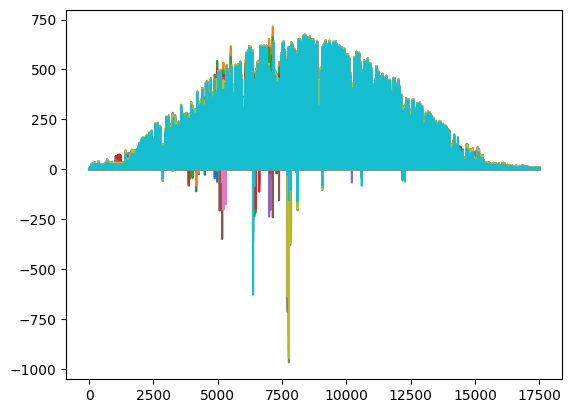

In [7]:
# this plot is kinda meaningless
plt.plot(pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"])